In [ ]:
from dalle2_pytorch.train_configs import DiffusionPriorConfig
import json
import torch
import torch
from dalle2_pytorch import DiffusionPrior, DiffusionPriorNetwork, OpenAIClipAdapter
from dalle2_pytorch.trainer import DiffusionPriorTrainer
import clip

In [3]:
import argparse, os, sys, glob
import torch
import numpy as np
from omegaconf import OmegaConf
from PIL import Image
from tqdm import tqdm, trange
from itertools import islice
from einops import rearrange
from torchvision.utils import make_grid
import time
from pytorch_lightning import seed_everything
from torch import autocast
from contextlib import contextmanager, nullcontext

from ldm.util import instantiate_from_config
from ldm.models.diffusion.ddim import DDIMSampler
from ldm.models.diffusion.plms import PLMSSampler
from scripts.image_variations import load_model_from_config

device = "cuda:0"

config = "../configs/stable-diffusion/sd-image-condition-finetune.yaml"
ckpt = "../models/ldm/stable-diffusion-v1/sd-clip-vit-l14-img-embed_ema_only.ckpt"
config = OmegaConf.load(config)
model = load_model_from_config(config, ckpt, device)

Loading model from ../models/ldm/stable-diffusion-v1/sd-clip-vit-l14-img-embed_ema_only.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 859.52 M params.
Keeping EMAs of 688.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 4, 32, 32) = 4096 dimensions.
making attention of type 'vanilla' with 512 in_channels


In [4]:

# use 0.15.4
def load_prior(model_path):
  prior_network = DiffusionPriorNetwork(
    dim=768,
    depth=24,
    dim_head=64,
    heads=32,
    normformer=True,
    attn_dropout=5e-2,
    ff_dropout=5e-2,
    num_time_embeds=1,
    num_image_embeds=1,
    num_text_embeds=1,
    num_timesteps=1000,
    ff_mult=4
  )

  diffusion_prior = DiffusionPrior(
    net=prior_network,
    clip=OpenAIClipAdapter("ViT-L/14"),
    image_embed_dim=768,
    timesteps=1000,
    cond_drop_prob=0.1,
    loss_type="l2",
    condition_on_text_encodings=True,
  ).to(device)

  state_dict = torch.load(model_path, map_location='cpu')
  if 'ema_model' in state_dict:
    print('Loading EMA Model')
    diffusion_prior.load_state_dict(state_dict['ema_model'], strict=True)
  else:
    print('Loading Standard Model')
    diffusion_prior.load_state_dict(state_dict['model'], strict=False)
  del state_dict
  return diffusion_prior

In [5]:
from dalle2_pytorch.train_configs import DiffusionPriorConfig, TrainDiffusionPriorConfig

def make_prior(
    prior_config: DiffusionPriorConfig, checkpoint_path: str, device: str = None
):
    # create model from config
    diffusion_prior = prior_config.create()
    state_dict = torch.load(checkpoint_path, map_location="cpu")
    diffusion_prior.load_state_dict(state_dict)
    diffusion_prior.eval()
    diffusion_prior.to(device)

    if device == "cpu":
        diffusion_prior.float()
    return diffusion_prior

# load entire config
train_config = TrainDiffusionPriorConfig.from_json_path("../../DALLE2-pytorch/pretrained/prior_config.json")
prior_config = train_config.prior

# load model
prior = make_prior(prior_config=prior_config, checkpoint_path="../../DALLE2-pytorch/pretrained/latest.pth", device=device)

In [18]:
# tokenize the text
tokenized_text = clip.tokenize("A watercolour painting of a moutain").to(device)
# predict an embedding, make sure to denormalise
predicted_embedding = prior.sample(tokenized_text, num_samples_per_batch=2, cond_scale=1.0)*prior.image_embed_scale

sampling loop time step:   0%|          | 0/64 [00:00<?, ?it/s]

In [20]:
plms = True
outdir = "prior2sd"
n_samples = 4
n_rows = 0
precision = "fp32"

ddim_steps = 50
scale = 3.0
ddim_eta = 0.0

if plms:
    sampler = PLMSSampler(model)
else:
    sampler = DDIMSampler(model)

os.makedirs(outdir, exist_ok=True)
outpath = outdir

batch_size = n_samples
n_rows = n_rows if n_rows > 0 else batch_size


sample_path = os.path.join(outpath, "samples")
os.makedirs(sample_path, exist_ok=True)
base_count = len(os.listdir(sample_path))
grid_count = len(os.listdir(outpath)) - 1

start_code = None

# c = torch.rand(n_samples, 1, 768, device=device)
c = predicted_embedding.tile(n_samples, 1).unsqueeze(1)

precision_scope = autocast if precision=="autocast" else nullcontext
with torch.no_grad():
    with precision_scope("cuda"):
        with model.ema_scope():
            tic = time.time()
            # c = model.get_learned_conditioning(prompts)

            uc = None
            if scale != 1.0:
                uc = torch.zeros_like(c)
            shape = [4, 512 // 8, 512 // 8]
            samples_ddim, _ = sampler.sample(S=ddim_steps,
                                             conditioning=c,
                                             batch_size=n_samples,
                                             shape=shape,
                                             verbose=False,
                                             unconditional_guidance_scale=scale,
                                             unconditional_conditioning=uc,
                                             eta=ddim_eta,
                                             x_T=start_code)

            x_samples_ddim = model.decode_first_stage(samples_ddim)
            x_samples_ddim = torch.clamp((x_samples_ddim + 1.0) / 2.0, min=0.0, max=1.0)

            for x_sample in x_samples_ddim:
                x_sample = 255. * rearrange(x_sample.cpu().numpy(), 'c h w -> h w c')
                Image.fromarray(x_sample.astype(np.uint8)).save(
                    os.path.join(sample_path, f"{base_count:05}.png"))
                base_count += 1


Data shape for PLMS sampling is (4, 4, 64, 64)
Running PLMS Sampling with 50 timesteps


PLMS Sampler: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [00:18<00:00,  2.74it/s]


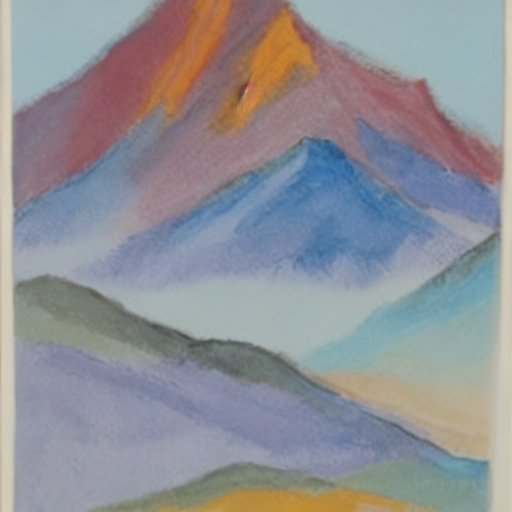

In [22]:
Image.open("prior2sd/samples/00000.png")